In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load the data, remove inactive students and impute missing values. 
I impute missing values manually, replacing with 'means' for symmetric cases [age] and 'median' for long-tailed ones [# videos and chapters].   

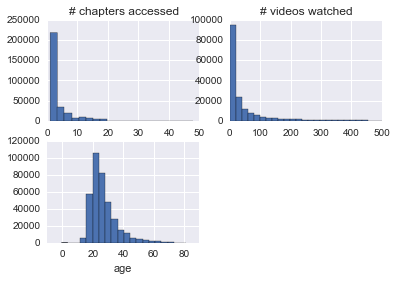

In [53]:
df = pd.read_csv('learn.csv')
sns.set_style('darkgrid')

temp = filter(lambda x: pd.notnull(x), df.nchapters)
plt.subplot(221, title = '# chapters accessed')
plt.hist(temp, 20);

temp = filter(lambda x: pd.notnull(x), df.nplay_video)
plt.subplot(222, title = '# videos watched')
plt.xlim(0, 500)
plt.hist(temp, 5000);

temp = filter(lambda x: pd.notnull(x), df.YoB)
course_yr = 2012.5
temp = map(lambda x: course_yr - x, temp)
plt.subplot(223)
plt.hist(temp, 20);
plt.xlabel('age')

##Churn = 1 for those who didn't complete the course.

In [54]:
# remove inactive students: those with 'nevents' being 'NaN'.
df = df[pd.notnull(df.nevents)]
df.index = range(df.shape[0])

temp = []
# Convert cathegoricals to numerics and impute missing values: 
for i in xrange(df.shape[0]): 
    if df['LoE_DI'][i] == 'Less than Secondary':
        temp.append(1)
    elif df['LoE_DI'][i] == 'Secondary':
        temp.append(2)
    elif df['LoE_DI'][i] == 'Bachelor\'s':
        temp.append(3)
    elif df['LoE_DI'][i] == 'Master\'s':
        temp.append(4)
    elif df['LoE_DI'][i] == 'Doctorate':
        temp.append(5)
    else:
        temp.append(0)
        
df['LoE_DI'] = temp
temp = []        
for i in xrange(df.shape[0]):
    if df['gender'][i] == 'm': #male
        temp.append(1)
    elif df['gender'][i] == 'f':
        temp.append(2)
    else:
        temp.append(0)
        
df['gender'] = temp
del temp

#Replace 'NaN' with mean or median
temp = filter(lambda x: pd.notnull(x), df.nchapters)
df['nchapters'].fillna(median(temp), inplace=True)

temp = filter(lambda x: pd.notnull(x), df.nplay_video)
df['nplay_video'].fillna(median(temp), inplace=True)

temp = filter(lambda x: pd.notnull(x), df.YoB)
df['YoB'].fillna(mean(temp), inplace=True)

#convert YoB to age:
course_yr = 2012.5
df['Age'] = df['YoB'].map(lambda x: course_yr - x)

#Convert 'certified' to 'Churn'
Churn = df['certified'].map(lambda x: 1 - x)
    
del df['YoB'], df['certified'], df['grade'], df['course_id']

In [55]:
df.head()

,viewed,explored,LoE_DI,gender,nevents,ndays_act,nplay_video,nchapters,nforum_posts,subject,instructor,no_courses,student_regis_to_launch,course_duration,last_event_to_launch,regis_open_to_launch,Age
0,1,1,0,0,502,16,50,12,0,10000000,366000,15,-4.000000,15.714286,31.857143,-11.571429,27.011261
1,1,0,0,0,42,6,18,3,0,1900000,600000,4,-10.285714,23.285714,8.714286,-12.714286,27.011261
2,1,0,0,0,70,3,18,3,0,1900000,600000,7,-3.571429,23.285714,0.571429,-12.714286,27.011261
3,1,0,0,0,17,2,18,2,0,500000000,500000,7,-1.285714,20.571429,14.571429,-11.142857,27.011261
4,1,0,0,0,32,1,18,3,0,500000000,500000,2,15.000000,20.571429,15.000000,-11.142857,27.011261


## Setting necessary learning, validation and plotting functions

In [6]:
def normalize(d_f): # normalize the features
    from sklearn import preprocessing
    X = d_f.as_matrix().astype(np.float)
    return preprocessing.scale(X)

def accuracy(y_true,y_pred): 
    return np.mean(y_true == y_pred)

In [11]:
def run_cv(X,features,y,clf_class,**kwargs): # makes cross-validated learning and predictions
    
    from sklearn.ensemble import RandomForestClassifier as RF
    from sklearn.cross_validation import KFold
    n_features = len(features)
    n_folds = 2
    
    kf = KFold(len(y),n_folds=n_folds,shuffle=True)
    y_pred = y.copy()
    feature_imprt = [0 for i in xrange(n_features)]
    
    #Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier 
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        
        if clf_class == RF:
            for i in xrange(n_features):
                feature_imprt[i] += clf.feature_importances_[i]/n_folds
            
        #print type(clf.feature_importances_)
    
    #print clf.get_params() 
    #for i in xrange(len(features)):
     #   print "%s: %.4f" % (features[i], ftr_impr[i]/n_folds) 
    
    imprt = {} # 'feature importances' in case of using random forrest classifier
    if clf_class == RF:
        for i in xrange(n_features):
            imprt[features[i]] = feature_imprt[i]
            #print "%s: %.3f" % (features[i], ftr_impr[i])        
    return y_pred, imprt    


### The churn (% of non-certified students) is high:

In [8]:
z = [Churn[i] for i in xrange(df.shape[0]) if Churn[i] == 1]
print "Churn rate is %d%%." % (100*len(z)/df.shape[0])

Churn rate is 96%.


###We can run a classifier on the data to predict student churn, however the problem is that data is highly unbalanced: 
96% of users do not get ceritifed at the end. A classifier that is trained on such unbalanced data can then be biased. In order to get around this, these are a list of actions that can be taken:
- **Using part of positive data**:

  One can make a balanced data set for training by choosing all minority records plus a random sample of the same size from majority class. The probelm is that most of the data (of positive class) is left out of training. 
  

- **Oversampling**:

  This involves oversampling the minority class to create a balanced data for training, by bootstrapping the minority class and adding small Gaussian noise to the features to prevent duplicates.  
  
  
  
  - **Using different penalty parameters**:
  
  One can use 'C-support vector classifier' and set the penalty parameter *C* inversely proportional to class frequencies. By doing so the classifier punishes misclassifying records belonging to the minority class more strongly. In scikit-learn this is implemented by setting *'class_weight = 'auto'*.  This is what I do here.  


In [16]:
from sklearn.svm import LinearSVC

X = normalize(df)
res = run_cv(X, df.columns, Churn, LinearSVC, class_weight='auto')
churn_pred = res[0]
print "Support vector machine accuracy: %.3f" % accuracy(Churn, churn_pred)

Support vector machine accuracy: 0.957


## How good is the classifier?

## Confusion matrix

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrices = [
    ( "LinearSVC", confusion_matrix(Churn,run_cv(X,df.columns, Churn, LinearSVC)[0])),
    ]

In [44]:
def plot_confusion_matrix(confusion_matrices):
    import matplotlib.pyplot as plt
    import numpy as np
    
    conf_arr = confusion_matrices
    norm_conf = []
    for i in conf_arr:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)
            
    fig = plt.figure()  
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, interpolation='nearest') 
    
    width = len(conf_arr)
    height = len(conf_arr[0])
    for x in xrange(width):
        for y in xrange(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center',
                        fontsize = 'xx-large')
            alphabet = ['retention','churn']
            plt.ylabel('True class', fontsize = 'xx-large')
            plt.xlabel('Pred. class', fontsize = 'xx-large')
            plt.yticks(range(height), alphabet[:height], fontsize = 'xx-large')
            plt.savefig('confusion_matrix.png', format='png')

## Recall and precision



Recall and precesion for SVC:  "recall=0.993, precision=0.986"



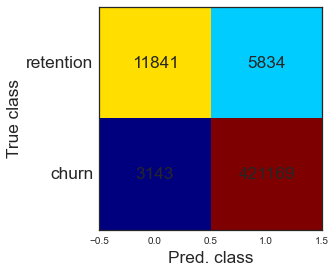

In [45]:
sns.set_style('white')
plot_confusion_matrix(confusion_matrices[0][1])
print "\n"

rf_conf = confusion_matrices[0][1]
print "Recall and precesion for SVC:  \"recall=%.3f, precision=%.3f\"\n" % (float(rf_conf[1][1])/
                                                  (rf_conf[1][1]+rf_conf[1][0]), 
                                                  float(rf_conf[1][1])/(rf_conf[1][1]+rf_conf[0][1]))

###I use random forrest classifier to get feature importances:

Random forest accuracy: 0.987


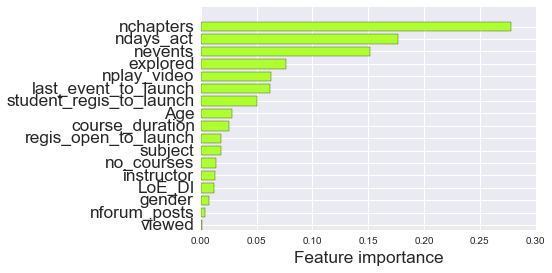

In [64]:
from sklearn.ensemble import RandomForestClassifier as RF

X = normalize(df)
res = run_cv(X,df.columns, Churn, RF)
churn_pred = res[0]
feat_impr = res[1]
print "Random forest accuracy: %.3f" % accuracy(Churn, churn_pred)

import operator
feat = []
impr = []
fi = sorted(feat_impr.items(), key=operator.itemgetter(1))
for i in xrange(len(feat_impr)):
    feat.append(fi[i][0])
    impr.append(fi[i][1])

N = X.shape[1]
ind = np.arange(N)    #x locations for the groups
width = 0.75       #width of the bars

import seaborn as sns
sns.set_style('darkgrid')

p1 = plt.barh(ind, impr, width, color='greenyellow')

plt.xlabel('Feature importance', fontsize = 'xx-large')
plt.yticks(ind+width/2., feat, rotation=0, fontsize = 'xx-large')
plt.savefig('feat_impr_certify.eps', format='eps')

plt.show()

### The certification rate is quite low, whereas view rate is high (~70%). Viewing the course content is also when ones starts to learn from the coruse. So, I classify students based on '*course view*'. 

In [61]:
df_view = df.copy()
viewed = df['viewed']
del df_view['viewed'], df_view['explored'], df_view['nevents'], df_view['ndays_act'], df_view['nplay_video'] 
del df_view['nchapters']#, df_view['nforum_posts']

In [62]:
df_view.head()

,LoE_DI,gender,nforum_posts,subject,instructor,no_courses,student_regis_to_launch,course_duration,last_event_to_launch,regis_open_to_launch,Age
0,0,0,0,10000000,366000,15,-4.000000,15.714286,31.857143,-11.571429,27.011261
1,0,0,0,1900000,600000,4,-10.285714,23.285714,8.714286,-12.714286,27.011261
2,0,0,0,1900000,600000,7,-3.571429,23.285714,0.571429,-12.714286,27.011261
3,0,0,0,500000000,500000,7,-1.285714,20.571429,14.571429,-11.142857,27.011261
4,0,0,0,500000000,500000,2,15.000000,20.571429,15.000000,-11.142857,27.011261


## Start with Random Forrest to get a sense of what features are important.

Random forest accuracy: 0.839


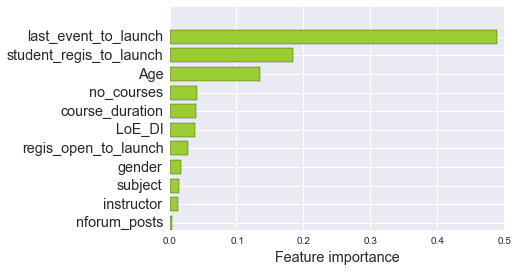

In [86]:
from sklearn.ensemble import RandomForestClassifier as RF

X = normalize(df_view)
res = run_cv(X, df_view.columns, viewed,RF)
view_pred = res[0]
feat_impr = res[1]
print "Random forest accuracy: %.3f" % accuracy(viewed, view_pred)

import operator
feat = []
impr = []
fi = sorted(feat_impr.items(), key=operator.itemgetter(1))
for i in xrange(len(feat_impr)):
    feat.append(fi[i][0])
    impr.append(fi[i][1])

N = len(feat)
ind = np.arange(N)   
width = 0.75      
import seaborn as sns
sns.set_style('darkgrid')

plt.barh(ind, impr, width, color='yellowgreen')

plt.xlabel('Feature importance', fontsize = 'x-large')
plt.yticks(ind+width/2., feat,rotation=0, fontsize = 'x-large')
#plt.savefig('feat_impr_view.eps', format='eps')

plt.show()

## Precision and recall

In [67]:
from sklearn.metrics import confusion_matrix
confusion_matrices = [
        ( "Random Forest", confusion_matrix(viewed, view_pred)),
    ]

rf_conf = confusion_matrices[0][1]
print "Accuracy, recal and precision of RF in predicting 'course view':\n\n  \"accuracy=%.3f, recall=%.3f, precision=%.3f\"\n" % (float(rf_conf[0][0]+rf_conf[1][1])/sum(rf_conf), float(rf_conf[1][1])/
                                                  (rf_conf[1][1]+rf_conf[1][0]), 
                                                  float(rf_conf[1][1])/(rf_conf[1][1]+rf_conf[0][1]))

Accuracy, recal and precision of RF in predicting 'course view':

  "accuracy=0.838, recall=0.909, precision=0.875"





Recall and precesion of random forrest classifier:  "recall=0.909, precision=0.875"



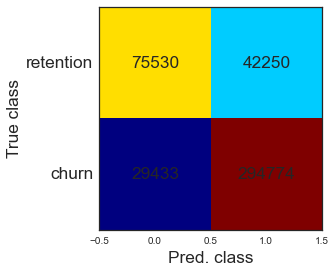

In [68]:
sns.set_style('white')
plot_confusion_matrix(rf_conf)
print "\n"

rf_conf = confusion_matrices[0][1]
print "Recall and precesion of random forrest classifier:  \"recall=%.3f, precision=%.3f\"\n" % (float(rf_conf[1][1])/
                                                  (rf_conf[1][1]+rf_conf[1][0]), 
                                                  float(rf_conf[1][1])/(rf_conf[1][1]+rf_conf[0][1]))
#print "SVC: \"recall=%.5f, precision=%.5f\"\n" % (float(svc_conf[1][1])/(svc_conf[1][1]+svc_conf[1][0]), float(svc_conf[1][1])/(svc_conf[1][1]+svc_conf[0][1]))

## Compare RF with a distance based algorithm, kNN.

## ROC curves

In [70]:
def plot_roc(X, y):
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style('white')

    from sklearn.ensemble import RandomForestClassifier as RF
    from sklearn.neighbors import KNeighborsClassifier as KNN

    from sklearn.metrics import roc_curve, auc
    from sklearn.cross_validation import train_test_split
    
    n_classes = 2
    n_samples, n_features = X.shape
    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=0)

    # Learn to predict each class against the other
    classifier = RF(n_estimators=20)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score[:,1])    
    roc_auc = auc(fpr, tpr)
    
    #KNN
    classifier = KNN(n_neighbors=20)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    fpr2, tpr2, _ = roc_curve(y_test, y_score[:,1])    
    roc_auc2 = auc(fpr2, tpr2)


    #Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='RF (area = %0.4f)' % roc_auc)
    plt.plot(fpr2, tpr2, label='kNN (area = %0.4f)' % roc_auc2)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize = 'x-large')
    plt.ylabel('True Positive Rate', fontsize = 'x-large')
    #plt.title('ROC curve')
    plt.legend(loc="lower right", fontsize = 'x-large')
    #plt.savefig('roc_view.eps', format='eps')
    plt.show()


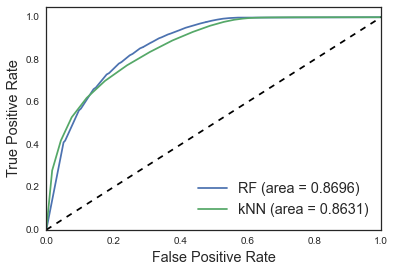

In [71]:
plot_roc(normalize(df_view), viewed)

### Therefore, the model has a good performance in terms of predicting whether or not student view the course content at all. What about predicting probabilities, which are more insightfull and actionable.

In [72]:
def prob_cv(X, y, clf_class, **kwargs):
    from sklearn.cross_validation import KFold

    kf = KFold(len(y), n_folds=2, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

In [75]:
from sklearn.neighbors import KNeighborsClassifier as KNN
pred_prob = prob_cv(normalize(df_view), viewed, KNN, n_neighbors=100)

pred_churn = pred_prob[:,0]
is_churn = viewed == 0

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    if sum(pred_churn == prob) > 100: # keep large groups only to reduce sampling errors. 
        true_prob[prob] = np.mean(is_churn[pred_churn == prob])


Predicted probabilities are close to the actual ones.


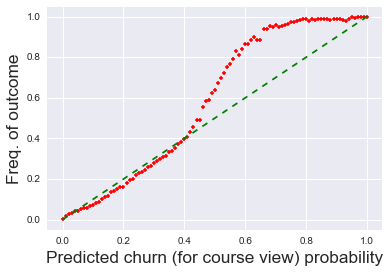

In [94]:
import collections
prob = collections.OrderedDict(sorted(true_prob.items()))

import seaborn as sns
sns.set_style('darkgrid')

#plt.plot(od.keys(), od.values(), color='b', markersize=12)
plt.xlim([-.05,1.05])
plt.ylim([-.05,1.05])
plt.plot(prob.keys(), prob.values(), '.', c='r')
plt.plot([0, 1], [0, 1], 'k--', c='g');
plt.xlabel('Predicted churn (for course view) probability', fontsize = 'xx-large')
plt.ylabel('Freq. of outcome', fontsize = 'xx-large')
#plt.savefig('prob.eps', format='eps')
print "\nPredicted probabilities are close to the actual ones."


## Repeat certification churn prediction this with part of the data with similar number of negative and and positive records. 

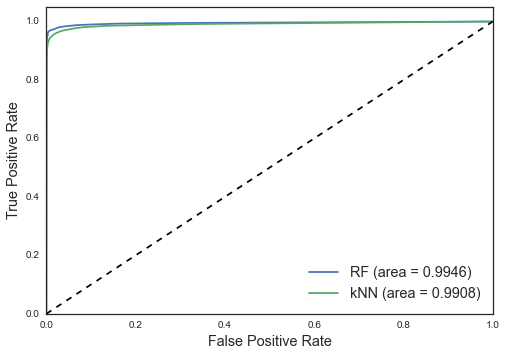

In [64]:
pos_to_neg = 1.5

df_pos = df[Churn == 1]
df_neg = df[Churn == 0]
df_pos.index = range(df_pos.shape[0])
# random sampling from df_pos
import random
rows = random.sample(df_pos.index, int(pos_to_neg*df_neg.shape[0]))
df_pos_samp = df_pos.ix[rows]
del df_pos

df_balanced = pd.concat([df_neg, df_pos_samp], ignore_index=True)

y = [0 for i in xrange(df_neg.shape[0])] + [1 for i in xrange(df_pos_samp.shape[0])]
y = np.array(y)


plot_roc(normalize(df_balanced), y)